# MIR

$$
\mathcal{L} = 
$$

In [1]:
%load_ext autoreload
%autoreload 2

# Libraries

In [2]:
import pickle
from tqdm import tqdm

In [3]:
from avalanche.benchmarks.classic import PermutedMNIST
from avalanche.models import SimpleMLP
from avalanche.training import MIR
from avalanche.training.plugins import EvaluationPlugin
from avalanche.logging import InteractiveLogger
from avalanche.evaluation.metrics import (
    accuracy_metrics,
    bwt_metrics,
    confusion_matrix_metrics,
    forgetting_metrics,
    timing_metrics,
    cpu_usage_metrics,
    gpu_usage_metrics,
    disk_usage_metrics,
    ram_usage_metrics,
    loss_metrics,
    class_accuracy_metrics,
    accuracy_matrix_metrics
)

from torch.nn import CrossEntropyLoss
from torch.optim import SGD
from torch import cuda

/Users/jesusoyanedelespinoza/.pyenv/versions/3.9.18/envs/tt2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Custom Libraries

In [4]:
import sys

sys.path.append("../base_code/")

from base_code.constants import DATASETS_PATH, SAVED_METRICS_PATH
from base_code.plugins import WeightStoragePlugin

# Constants

In [5]:
TORCH_DEVICE = "cuda" if cuda.is_available() else "cpu"
N_EXPERIENCES = 10
EXPERIMENT_SEED = 1234
METRICS_SUBFOLDER = "standard"
METRICS_FILENAME = f"{METRICS_SUBFOLDER}/mir.pkl"

# Dataset and definitions

## Dataset loading

We load state-of-the-art dataset Modified NIST

In [6]:
scenario = PermutedMNIST(N_EXPERIENCES, seed=EXPERIMENT_SEED, dataset_root=DATASETS_PATH)

## Scenario creation with train test streaming

In this point, we define our scenario considering a training where in every experience of it, a new class is presented. This is, first we train with a class $a$, the following experience we train with class $b$ ($a \neq b$)

In [7]:
train_stream = scenario.train_stream
test_stream = scenario.test_stream

# Model Selection

In [8]:
from math import floor
from itertools import product
from typing import List

# Constants
MODEL_SELECTION_MAX_EXPERIENCES = floor(N_EXPERIENCES * 0.2)

strategy_hyperparameters_grid = {
    "mem_size": [10, 50, 100, 200, 300, 400],
    "subsample": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
}

# Create the models
models = [
    SimpleMLP(num_classes=scenario.n_classes, hidden_size=100, input_size=28 * 28).to(TORCH_DEVICE)
    for _ in product(*strategy_hyperparameters_grid.values())
]
hyperparameters_product = list(product(*strategy_hyperparameters_grid.values()))

strategies: List[MIR] = []
for model, hyperparameters in zip(models, hyperparameters_product):
    strategy = MIR(
        model,
        SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005),
        CrossEntropyLoss(),
        batch_size_mem=100,
        train_mb_size=100,
        train_epochs=1,
        eval_mb_size=100,
        device=TORCH_DEVICE,
        evaluator=EvaluationPlugin(
            accuracy_metrics(
                stream=True
            ),
        ),
        **dict(zip(strategy_hyperparameters_grid.keys(), hyperparameters)),
    )
    strategies.append(strategy)

# train each model on the first 20% of the experiences
for i, strategy in enumerate(strategies):
    print(f"Training model {i + 1}/{len(strategies)}")
    for experience in train_stream[:MODEL_SELECTION_MAX_EXPERIENCES]:
        strategy.train(experience)
    strategy.eval(train_stream[:MODEL_SELECTION_MAX_EXPERIENCES])


/Users/jesusoyanedelespinoza/.pyenv/versions/3.9.18/envs/tt2/lib/python3.9/site-packages/avalanche/training/plugins/evaluation.py:94: UserWarning: No loggers specified, metrics will not be logged
  warnings.warn("No loggers specified, metrics will not be logged")


Training model 1/60
Training model 2/60
Training model 3/60
Training model 4/60
Training model 5/60
Training model 6/60
Training model 7/60
Training model 8/60
Training model 9/60
Training model 10/60
Training model 11/60
Training model 12/60
Training model 13/60
Training model 14/60
Training model 15/60
Training model 16/60
Training model 17/60
Training model 18/60
Training model 19/60
Training model 20/60
Training model 21/60
Training model 22/60
Training model 23/60
Training model 24/60
Training model 25/60
Training model 26/60
Training model 27/60
Training model 28/60
Training model 29/60
Training model 30/60
Training model 31/60
Training model 32/60
Training model 33/60
Training model 34/60
Training model 35/60
Training model 36/60
Training model 37/60
Training model 38/60
Training model 39/60
Training model 40/60
Training model 41/60
Training model 42/60
Training model 43/60
Training model 44/60
Training model 45/60
Training model 46/60
Training model 47/60
Training model 48/60
T

In [9]:
# Get the model with the best averaged accuracy
best_hyperparameters_idx = -1
best_avg_accuracy = 0

for i, strategy in enumerate(strategies):
    avg_accuracy = strategy.evaluator.get_last_metrics()["Top1_Acc_Stream/eval_phase/train_stream/Task000"]
    if avg_accuracy > best_avg_accuracy:
        best_avg_accuracy = avg_accuracy
        best_hyperparameters_idx = i

best_hyperparameters = dict(zip(strategy_hyperparameters_grid.keys(), hyperparameters_product[best_hyperparameters_idx]))

In [10]:
best_hyperparameters

{'mem_size': 50, 'subsample': 5}

## Evaluation metrics definition

In [11]:
eval_plugin = EvaluationPlugin(
    accuracy_metrics(experience=True, stream=True),
    loss_metrics(minibatch=True, experience=True, stream=True),
    timing_metrics(epoch=True, epoch_running=True),
    cpu_usage_metrics(minibatch=True, experience=True, stream=True),
    gpu_usage_metrics(experience=True, stream=True, gpu_id=TORCH_DEVICE),
    disk_usage_metrics(experience=True, stream=True),
    ram_usage_metrics(experience=True, stream=True),
    class_accuracy_metrics(experience=True, stream=True),
    accuracy_matrix_metrics(),
    forgetting_metrics(experience=True, stream=True),
    bwt_metrics(experience=True, stream=True),
    confusion_matrix_metrics(stream=True, num_classes=scenario.n_classes),
    
    loggers=[InteractiveLogger()]
)

/Users/jesusoyanedelespinoza/.pyenv/versions/3.9.18/envs/tt2/lib/python3.9/site-packages/avalanche/evaluation/metrics/gpu_usage.py:56: UserWarning: Your system has no GPU!
  warnings.warn("Your system has no GPU!")
/Users/jesusoyanedelespinoza/.pyenv/versions/3.9.18/envs/tt2/lib/python3.9/site-packages/avalanche/evaluation/metrics/gpu_usage.py:56: UserWarning: Your system has no GPU!
  warnings.warn("Your system has no GPU!")


## Plugin defitinitions

In [12]:
model_plugins = [WeightStoragePlugin()]

## Model, Optimizer, Loss function and Strategy definition

* `model`: Multi Layer Perceptron
* `Optimizer`: Adam
* `Loss function`: Cross Entropy
* `Strategy`: Elastic Weight Consolidation

In [13]:
model = SimpleMLP(num_classes=scenario.n_classes, input_size=28 * 28, hidden_layers=2, hidden_size=100).to(TORCH_DEVICE)
optimizer = SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.0005)
criterion = CrossEntropyLoss().to(TORCH_DEVICE)
strategy = MIR(
    model,
    optimizer,
    criterion,
    train_epochs=5,
    batch_size_mem=128,
    train_mb_size=128,
    plugins=model_plugins,
    evaluator=eval_plugin,
    eval_mb_size=128,
    device=TORCH_DEVICE,
    **best_hyperparameters
)

# Training and evaluation

Revisar porque el entrenamiento se está comportando de forma rara

  0%|          | 0/10 [00:00<?, ?it/s]

-- >> Start of training phase << --
100%|██████████| 469/469 [00:04<00:00, 115.69it/s]
Epoch 0 ended.
	CPUUsage_MB/train_phase/train_stream/Task000 = 108.9000
	Loss_MB/train_phase/train_stream/Task000 = 1.1991
	RunningTime_Epoch/train_phase/train_stream/Task000 = 0.0000
	Time_Epoch/train_phase/train_stream/Task000 = 4.0544
100%|██████████| 469/469 [00:04<00:00, 116.18it/s]
Epoch 1 ended.
	CPUUsage_MB/train_phase/train_stream/Task000 = 115.4000
	Loss_MB/train_phase/train_stream/Task000 = 0.8169
	RunningTime_Epoch/train_phase/train_stream/Task000 = 0.0000
	Time_Epoch/train_phase/train_stream/Task000 = 4.0370
100%|██████████| 469/469 [00:04<00:00, 116.23it/s]
Epoch 2 ended.
	CPUUsage_MB/train_phase/train_stream/Task000 = 112.9000
	Loss_MB/train_phase/train_stream/Task000 = 0.6398
	RunningTime_Epoch/train_phase/train_stream/Task000 = 0.0000
	Time_Epoch/train_phase/train_stream/Task000 = 4.0356
100%|██████████| 469/469 [00:04<00:00, 117.24it/s]
Epoch 3 ended.
	CPUUsage_MB/train_phase/train_

 10%|█         | 1/10 [00:30<04:33, 30.39s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 106.3193
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x140584a60>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 2935.2314
	EvalStream/Acc_Matrix = 
tensor([[0.9133, 0.1309, 0.1501, 0.1310, 0.1243, 0.0892, 0.1237, 0.1106, 0.1166,
         0.1715],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
    

 20%|██        | 2/10 [00:59<03:59, 29.89s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 104.9981
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x141977d30>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 2935.2314
	EvalStream/Acc_Matrix = 
tensor([[0.9133, 0.1309, 0.1501, 0.1310, 0.1243, 0.0892, 0.1237, 0.1106, 0.1166,
         0.1715],
        [0.8939, 0.9257, 0.1324, 0.1017, 0.1329, 0.0772, 0.1141, 0.0939, 0.1376,
         0.1819],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
    

 30%|███       | 3/10 [01:56<04:54, 42.05s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 105.1702
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x1418bd6a0>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 2935.2314
	EvalStream/Acc_Matrix = 
tensor([[0.9133, 0.1309, 0.1501, 0.1310, 0.1243, 0.0892, 0.1237, 0.1106, 0.1166,
         0.1715],
        [0.8939, 0.9257, 0.1324, 0.1017, 0.1329, 0.0772, 0.1141, 0.0939, 0.1376,
         0.1819],
        [0.8807, 0.8967, 0.9314, 0.0861, 0.1214, 0.0982, 0.0886, 0.0955, 0.1184,
         0.1621],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
    

 40%|████      | 4/10 [02:27<03:46, 37.79s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 105.5126
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x1405273a0>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 2935.2314
	EvalStream/Acc_Matrix = 
tensor([[0.9133, 0.1309, 0.1501, 0.1310, 0.1243, 0.0892, 0.1237, 0.1106, 0.1166,
         0.1715],
        [0.8939, 0.9257, 0.1324, 0.1017, 0.1329, 0.0772, 0.1141, 0.0939, 0.1376,
         0.1819],
        [0.8807, 0.8967, 0.9314, 0.0861, 0.1214, 0.0982, 0.0886, 0.0955, 0.1184,
         0.1621],
        [0.8430, 0.8736, 0.9112, 0.9376, 0.0852, 0.0765, 0.0930, 0.0960, 0.1033,
         0.1381],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
    

 50%|█████     | 5/10 [02:59<02:57, 35.53s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 105.0824
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x141888220>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 2935.2314
	EvalStream/Acc_Matrix = 
tensor([[0.9133, 0.1309, 0.1501, 0.1310, 0.1243, 0.0892, 0.1237, 0.1106, 0.1166,
         0.1715],
        [0.8939, 0.9257, 0.1324, 0.1017, 0.1329, 0.0772, 0.1141, 0.0939, 0.1376,
         0.1819],
        [0.8807, 0.8967, 0.9314, 0.0861, 0.1214, 0.0982, 0.0886, 0.0955, 0.1184,
         0.1621],
        [0.8430, 0.8736, 0.9112, 0.9376, 0.0852, 0.0765, 0.0930, 0.0960, 0.1033,
         0.1381],
        [0.8173, 0.8363, 0.8970, 0.9088, 0.9382, 0.0931, 0.0804, 0.1020, 0.1242,
         0.1687],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
    

 60%|██████    | 6/10 [03:30<02:16, 34.14s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 105.5583
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x1404d3160>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 2935.2314
	EvalStream/Acc_Matrix = 
tensor([[0.9133, 0.1309, 0.1501, 0.1310, 0.1243, 0.0892, 0.1237, 0.1106, 0.1166,
         0.1715],
        [0.8939, 0.9257, 0.1324, 0.1017, 0.1329, 0.0772, 0.1141, 0.0939, 0.1376,
         0.1819],
        [0.8807, 0.8967, 0.9314, 0.0861, 0.1214, 0.0982, 0.0886, 0.0955, 0.1184,
         0.1621],
        [0.8430, 0.8736, 0.9112, 0.9376, 0.0852, 0.0765, 0.0930, 0.0960, 0.1033,
         0.1381],
        [0.8173, 0.8363, 0.8970, 0.9088, 0.9382, 0.0931, 0.0804, 0.1020, 0.1242,
         0.1687],
        [0.7255, 0.7832, 0.8680, 0.9065, 0.9166, 0.9372, 0.0915, 0.0985, 0.1107,
         0.1180],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
    

 70%|███████   | 7/10 [04:01<01:39, 33.20s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 105.3734
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x142c96d00>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 2935.2314
	EvalStream/Acc_Matrix = 
tensor([[0.9133, 0.1309, 0.1501, 0.1310, 0.1243, 0.0892, 0.1237, 0.1106, 0.1166,
         0.1715],
        [0.8939, 0.9257, 0.1324, 0.1017, 0.1329, 0.0772, 0.1141, 0.0939, 0.1376,
         0.1819],
        [0.8807, 0.8967, 0.9314, 0.0861, 0.1214, 0.0982, 0.0886, 0.0955, 0.1184,
         0.1621],
        [0.8430, 0.8736, 0.9112, 0.9376, 0.0852, 0.0765, 0.0930, 0.0960, 0.1033,
         0.1381],
        [0.8173, 0.8363, 0.8970, 0.9088, 0.9382, 0.0931, 0.0804, 0.1020, 0.1242,
         0.1687],
        [0.7255, 0.7832, 0.8680, 0.9065, 0.9166, 0.9372, 0.0915, 0.0985, 0.1107,
         0.1180],
        [0.6899, 0.7149, 0.7964, 0.8749, 0.8780, 0.9234, 0.9377, 0.0999, 0.1168,
         0.1362],
    

 80%|████████  | 8/10 [04:33<01:05, 32.58s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 105.5908
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x1419213a0>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 2935.2314
	EvalStream/Acc_Matrix = 
tensor([[0.9133, 0.1309, 0.1501, 0.1310, 0.1243, 0.0892, 0.1237, 0.1106, 0.1166,
         0.1715],
        [0.8939, 0.9257, 0.1324, 0.1017, 0.1329, 0.0772, 0.1141, 0.0939, 0.1376,
         0.1819],
        [0.8807, 0.8967, 0.9314, 0.0861, 0.1214, 0.0982, 0.0886, 0.0955, 0.1184,
         0.1621],
        [0.8430, 0.8736, 0.9112, 0.9376, 0.0852, 0.0765, 0.0930, 0.0960, 0.1033,
         0.1381],
        [0.8173, 0.8363, 0.8970, 0.9088, 0.9382, 0.0931, 0.0804, 0.1020, 0.1242,
         0.1687],
        [0.7255, 0.7832, 0.8680, 0.9065, 0.9166, 0.9372, 0.0915, 0.0985, 0.1107,
         0.1180],
        [0.6899, 0.7149, 0.7964, 0.8749, 0.8780, 0.9234, 0.9377, 0.0999, 0.1168,
         0.1362],
    

 90%|█████████ | 9/10 [05:04<00:32, 32.26s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 105.4885
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x14063ad00>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 2935.2314
	EvalStream/Acc_Matrix = 
tensor([[0.9133, 0.1309, 0.1501, 0.1310, 0.1243, 0.0892, 0.1237, 0.1106, 0.1166,
         0.1715],
        [0.8939, 0.9257, 0.1324, 0.1017, 0.1329, 0.0772, 0.1141, 0.0939, 0.1376,
         0.1819],
        [0.8807, 0.8967, 0.9314, 0.0861, 0.1214, 0.0982, 0.0886, 0.0955, 0.1184,
         0.1621],
        [0.8430, 0.8736, 0.9112, 0.9376, 0.0852, 0.0765, 0.0930, 0.0960, 0.1033,
         0.1381],
        [0.8173, 0.8363, 0.8970, 0.9088, 0.9382, 0.0931, 0.0804, 0.1020, 0.1242,
         0.1687],
        [0.7255, 0.7832, 0.8680, 0.9065, 0.9166, 0.9372, 0.0915, 0.0985, 0.1107,
         0.1180],
        [0.6899, 0.7149, 0.7964, 0.8749, 0.8780, 0.9234, 0.9377, 0.0999, 0.1168,
         0.1362],
    

100%|██████████| 10/10 [05:36<00:00, 33.60s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 105.5906
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x153049ac0>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 2935.2314
	EvalStream/Acc_Matrix = 
tensor([[0.9133, 0.1309, 0.1501, 0.1310, 0.1243, 0.0892, 0.1237, 0.1106, 0.1166,
         0.1715],
        [0.8939, 0.9257, 0.1324, 0.1017, 0.1329, 0.0772, 0.1141, 0.0939, 0.1376,
         0.1819],
        [0.8807, 0.8967, 0.9314, 0.0861, 0.1214, 0.0982, 0.0886, 0.0955, 0.1184,
         0.1621],
        [0.8430, 0.8736, 0.9112, 0.9376, 0.0852, 0.0765, 0.0930, 0.0960, 0.1033,
         0.1381],
        [0.8173, 0.8363, 0.8970, 0.9088, 0.9382, 0.0931, 0.0804, 0.1020, 0.1242,
         0.1687],
        [0.7255, 0.7832, 0.8680, 0.9065, 0.9166, 0.9372, 0.0915, 0.0985, 0.1107,
         0.1180],
        [0.6899, 0.7149, 0.7964, 0.8749, 0.8780, 0.9234, 0.9377, 0.0999, 0.1168,
         0.1362],
    

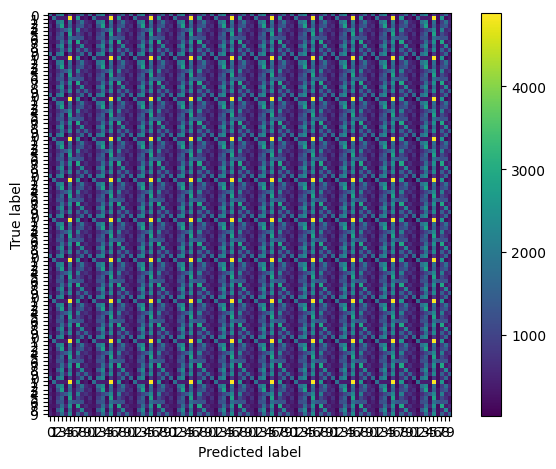

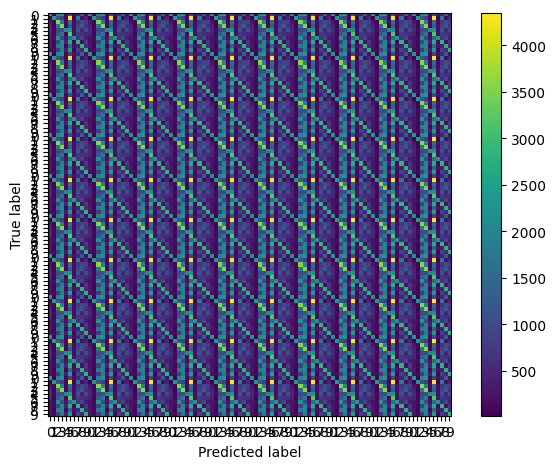

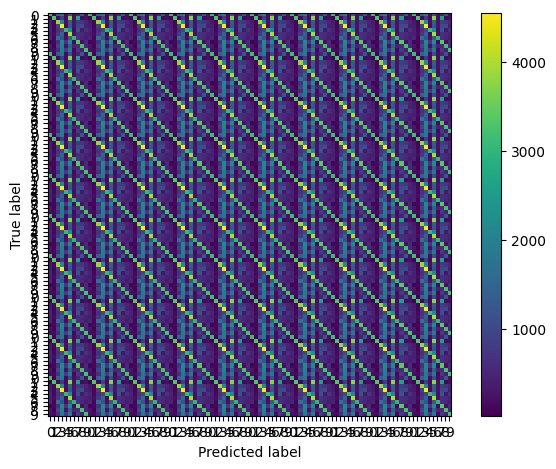

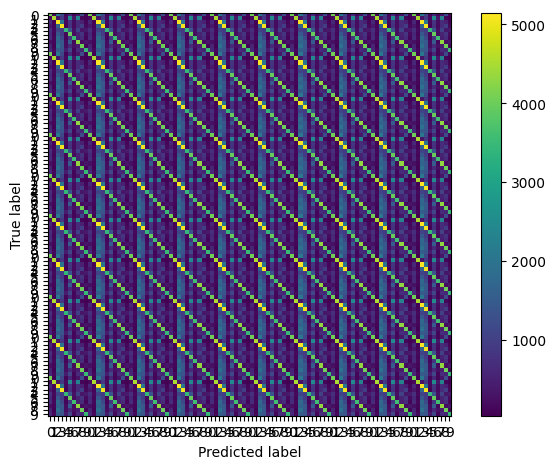

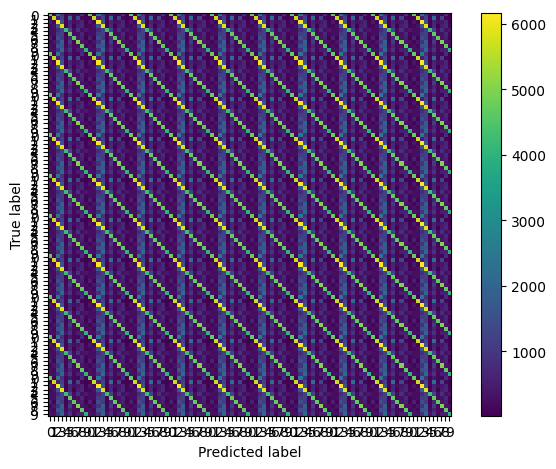

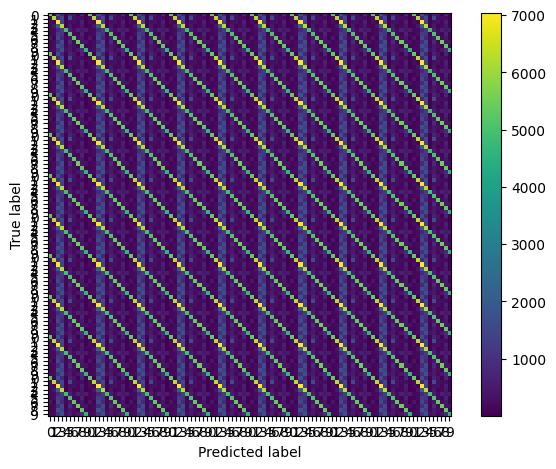

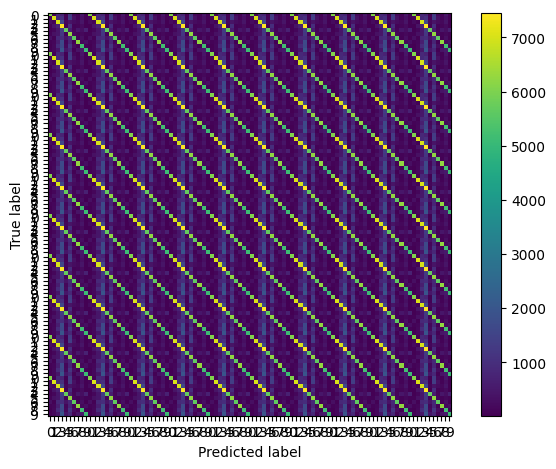

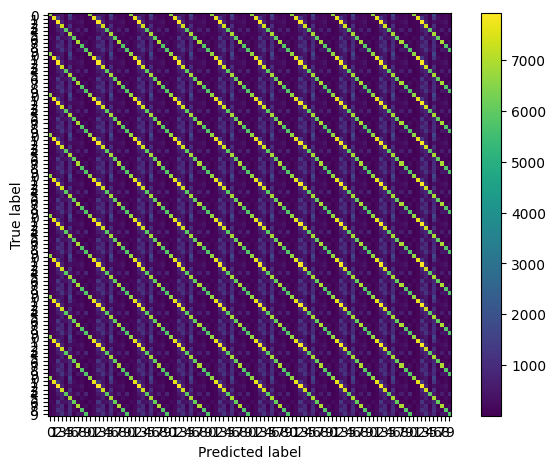

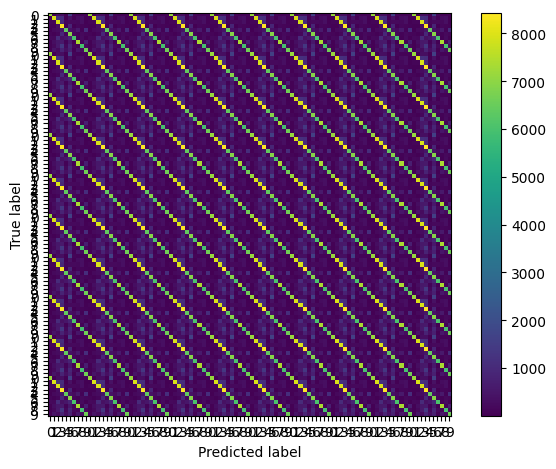

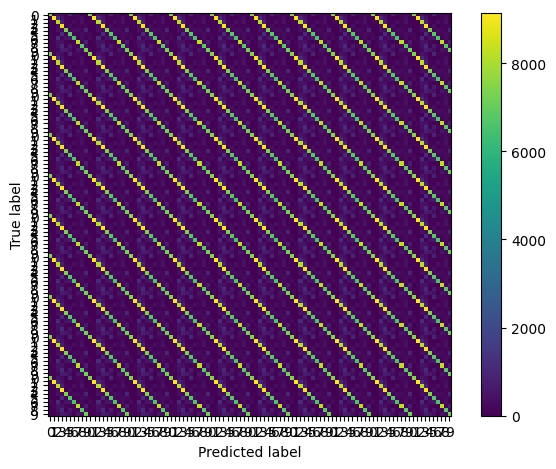

In [14]:
for experience in tqdm(train_stream):
    strategy.train(experience)
    strategy.eval(test_stream)

# Get metrics

In [15]:
accuracies: dict[int, list[float]] = dict()
forgettings: dict[int, list[float]] = dict()
bwt: dict[int, list[float]] = dict()
class_accuracies: dict[int, list[float]] = dict()
losses: dict[int, list[float]] = dict()

for i in range(N_EXPERIENCES):
    filled_i = str(i).zfill(3)
    accuracies[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp{filled_i}"
    ][1]
    forgettings[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"ExperienceForgetting/eval_phase/test_stream/Task000/Exp{filled_i}"
    ][1]
    bwt[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"ExperienceBWT/eval_phase/test_stream/Task000/Exp{filled_i}"
    ][1]
    class_accuracies[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/{i}"
    ][1]
    losses[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"Loss_Exp/eval_phase/test_stream/Task000/Exp{filled_i}"
    ][1]
        

accuracies["Overall"] = eval_plugin.get_all_metrics()[
    "Top1_Acc_Stream/eval_phase/test_stream/Task000"
][1]

In [16]:
train_cpu_usage = eval_plugin.get_all_metrics()["CPUUsage_MB/train_phase/train_stream/Task000"][1]
train_time_epoch = eval_plugin.get_all_metrics()["Time_Epoch/train_phase/train_stream/Task000"][1]
train_running_time = eval_plugin.get_all_metrics()["RunningTime_Epoch/train_phase/train_stream/Task000"][1]
train_loss_epoch = eval_plugin.get_all_metrics()["Loss_MB/train_phase/train_stream/Task000"][1]

In [17]:
weights = model_plugins[0].weights

# Store metrics

In [18]:
pickle.dump({
    "accuracies": accuracies,
    "forgettings": forgettings,
    "bwt": bwt,
    "class_accuracies": class_accuracies,
    "losses": losses,
    "train_cpu_usage": train_cpu_usage,
    "train_time_epoch": train_time_epoch,
    "train_running_time": train_running_time,
    "train_loss_epoch": train_loss_epoch,
    "weights": weights
}, open(SAVED_METRICS_PATH / METRICS_FILENAME, "wb"))